# Permeation barrier model

Base model for shield permeation barrier modeling

In [1]:
import festim as F
import numpy as np
from timelag_analysis_functions import *

In [2]:
print(F.__version__)

2.0a7


In [3]:
my_model = F.HydrogenTransportProblem()

substrate_thick = 1e-3  # m
# Temperature will be set after defining T_func in next cell
w_atom_density = 6.3e28  # atom/m3
# SS_atom_density = 8.5e28  # atom/m3


tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
    )

# # actually stainless steel
# tungsten = F.Material(
#     D_0=5.91e-7,
#     E_D=0.56,
#     K_S_0=1.35e22,
#     E_K_S=0.29,
#     )

In [4]:
import ufl

# # ---- User inputs ----
# base_run_length = 4e4 # s (base run length for 600K)
# bake_length = 1e5 # s
# runs_per_temp = 3 # number of runs at each temperature



# SS
# ---- User inputs ----
base_run_length = 2e5 # s (base run length for 600K)
bake_length = 3.6e5 # s
runs_per_temp = 3 # number of runs at each temperature



P_run = 1.0e5 # pressure during runs (Pa)
P_bake = 0.0 # pressure during bakes (Pa)

# # Temperature cycling: start high, step down, then step back up
# temperatures = [650, 600, 550, 600, 650]  # K
# # This gives: 3 runs @ 600K, 3 @ 550K, 3 @ 500K, 3 @ 550K, 3 @ 600K
# # Total: 15 runs

# # Temperature-dependent run lengths (550K gets 50% more time, 500K gets 125% more time)
# run_length_map = {
#     650: base_run_length,
#     600: base_run_length * 1.4,
#     550: base_run_length * 1.8,  # Fixed: was using 1.5**2 which evaluated incorrectly
# }


# SS
# Temperature cycling: start high, step down, then step back up
temperatures = [600, 550, 500, 550, 600]  # K
# This gives: 3 runs @ 600K, 3 @ 550K, 3 @ 500K, 3 @ 550K, 3 @ 600K
# Total: 15 runs

# Temperature-dependent run lengths (550K gets 50% more time, 500K gets 125% more time)
run_length_map = {
    600: base_run_length,
    550: base_run_length * 1.4,
    500: base_run_length * 1.8,  # Fixed: was using 1.5**2 which evaluated incorrectly
}



# ---- Build milestones and temperature schedule ----
milestones = []
temp_schedule = []  # list of (time_end, temperature) pairs for each segment
t_curr = 0.0

for temp_idx, temp in enumerate(temperatures):
    run_length = run_length_map[temp]
    
    for run_idx in range(runs_per_temp):
        # end of run
        t_curr += run_length
        milestones.append(t_curr)
        temp_schedule.append((t_curr, temp, 'run'))
        
        # end of bake (except after the very last run)
        is_last_run = (temp_idx == len(temperatures) - 1) and (run_idx == runs_per_temp - 1)
        if not is_last_run:
            t_curr += bake_length
            milestones.append(t_curr)
            temp_schedule.append((t_curr, temp, 'bake'))

# total simulated time
final_time = t_curr

print(f"Total runs: {len(temperatures) * runs_per_temp}")
print(f"Total time: {final_time:.2e} s")
print(f"Milestones: {len(milestones)}")
print(milestones)
print(f"\nRun lengths by temperature:")
for temp, length in run_length_map.items():
    print(f"  {temp}K: {length:.2e} s")
print(f"\nTemperature schedule:")
for i, (t_end, temp, phase) in enumerate(temp_schedule):
    print(f"  Segment {i+1}: {phase:4s} @ {temp}K until t={t_end:.2e} s")


def _build_pressure_expr(t, temp_schedule, P_run, P_bake):
    """
    Internal helper that builds the nested ufl.conditional expression for pressure.
    """
    expr = P_run  # fallback after last milestone: run
    for k in reversed(range(len(temp_schedule))):
        _, _, phase = temp_schedule[k]
        value_here = P_run if phase == 'run' else P_bake
        expr = ufl.conditional(
            ufl.le(t, temp_schedule[k][0]),
            value_here,
            expr,
        )
    return expr


def P_up(t):
    """
    Pressure function with FESTIM-compatible signature.
    """
    return _build_pressure_expr(t, temp_schedule, P_run, P_bake)


def T_func(t):
    """
    Temperature function with FESTIM-compatible signature.
    Uses Python conditionals (not ufl.conditional) based on the example.
    """
    # Check each milestone from the end backwards
    for k in range(len(temp_schedule) - 1, -1, -1):
        t_end, temp, _ = temp_schedule[k]
        if t <= t_end:
            return temp
    
    # Fallback: return last temperature
    return temp_schedule[-1][1]

Total runs: 15
Total time: 9.00e+06 s
Milestones: 29
[200000.0, 560000.0, 760000.0, 1120000.0, 1320000.0, 1680000.0, 1960000.0, 2320000.0, 2600000.0, 2960000.0, 3240000.0, 3600000.0, 3960000.0, 4320000.0, 4680000.0, 5040000.0, 5400000.0, 5760000.0, 6040000.0, 6400000.0, 6680000.0, 7040000.0, 7320000.0, 7680000.0, 7880000.0, 8240000.0, 8440000.0, 8800000.0, 9000000.0]

Run lengths by temperature:
  600K: 2.00e+05 s
  550K: 2.80e+05 s
  500K: 3.60e+05 s

Temperature schedule:
  Segment 1: run  @ 600K until t=2.00e+05 s
  Segment 2: bake @ 600K until t=5.60e+05 s
  Segment 3: run  @ 600K until t=7.60e+05 s
  Segment 4: bake @ 600K until t=1.12e+06 s
  Segment 5: run  @ 600K until t=1.32e+06 s
  Segment 6: bake @ 600K until t=1.68e+06 s
  Segment 7: run  @ 550K until t=1.96e+06 s
  Segment 8: bake @ 550K until t=2.32e+06 s
  Segment 9: run  @ 550K until t=2.60e+06 s
  Segment 10: bake @ 550K until t=2.96e+06 s
  Segment 11: run  @ 550K until t=3.24e+06 s
  Segment 12: bake @ 550K until t=3

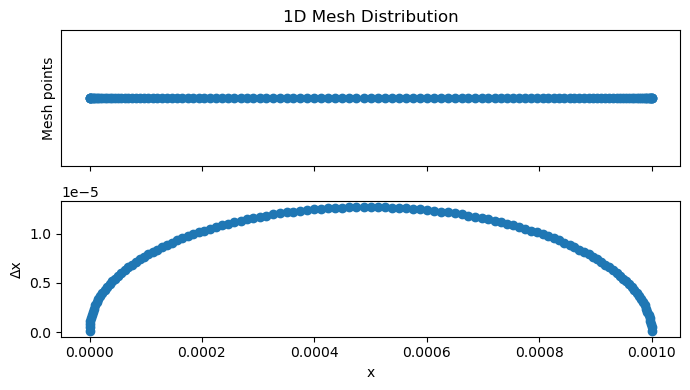

Solving HydrogenTransportProblem:  22%|██▏       | 1.95M/9.00M [00:45<01:37, 72.2kit/s]

RuntimeError: Newton solver did not converge because maximum number of iterations reached

In [5]:
# Set the temperature function (defined in previous cell)
my_model.temperature = T_func

# Set up model
H, trapped_H1, trapped_H2, empty_trap1, empty_trap2 = define_species(my_model, w_atom_density)


N = 125
s = np.linspace(0, 1, N)
vertices = substrate_thick * 0.5 * (1 - np.cos(np.pi * s))
plot_1d_mesh(vertices)

# vertices = np.linspace(0, substrate_thick, num=250)

my_model.mesh = F.Mesh1D(vertices)

volume_subdomain, left_boundary, right_boundary = define_BCs_and_initial_conditions(
    my_model, tungsten, substrate_thick, H, P_up
)

define_trapping_reactions(my_model, H, trapped_H1, trapped_H2, empty_trap1, empty_trap2, volume_subdomain, w_atom_density)

# settings(my_model, final_time, milestones=milestones)

# Enforce small timesteps for 1000 seconds after each milestone
# settings(
#     my_model, 
#     final_time, 
#     growth_factor=1.05,
#     cutback_factor=0.9,
#     max_stepsize=300,
#     milestones=milestones,
#     pre_milestone_duration = 1e3,
#     post_milestone_duration = 1e3,
#     initial_value = 50
# )

settings(
    my_model, 
    final_time, 
    growth_factor=1.05,
    cutback_factor=0.9,
    max_stepsize=500,
    milestones=milestones,
    pre_milestone_duration = 1e4,
    post_milestone_duration = 1e4,
    initial_value = 20
)

# # SS
# settings(
#     my_model, 
#     final_time, 
#     growth_factor=1.25,
#     cutback_factor=0.2,
#     max_stepsize=300,
#     milestones=milestones,
#     pre_milestone_duration = 1e3,
#     post_milestone_duration = 1e3,
#     initial_value = 10
# )

permeation_flux = F.SurfaceFlux(field=H, surface=right_boundary)

my_model.exports = [permeation_flux]

total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)

my_model.initialise()

my_model.run()

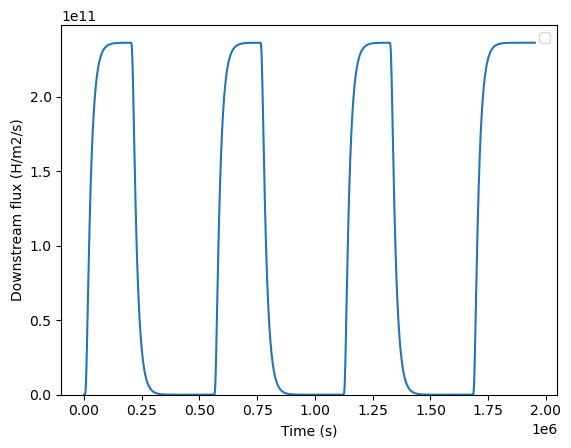

Solving HydrogenTransportProblem:  22%|██▏       | 1.95M/9.00M [01:00<01:37, 72.2kit/s]

In [ ]:
times = permeation_flux.t

import matplotlib.pyplot as plt

plt.plot(times, np.abs(permeation_flux.data))
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.legend()
plt.show()

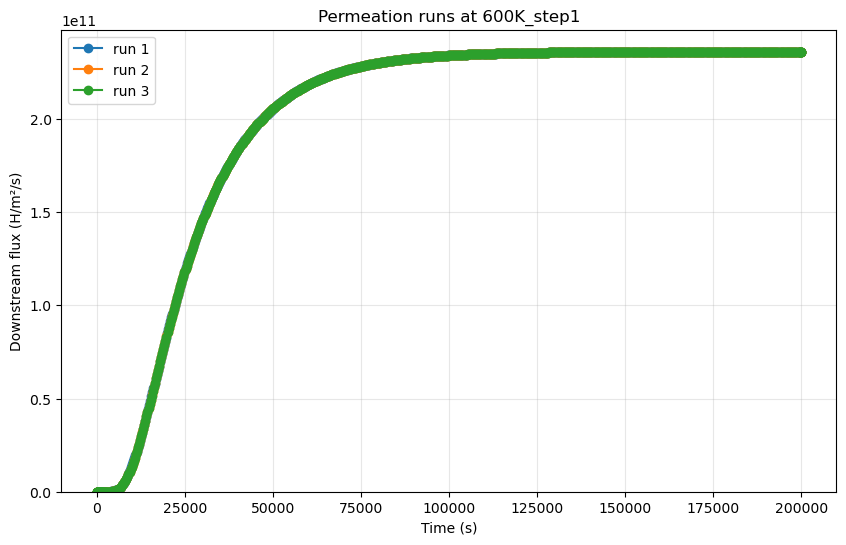

IndexError: index 0 is out of bounds for axis 0 with size 0

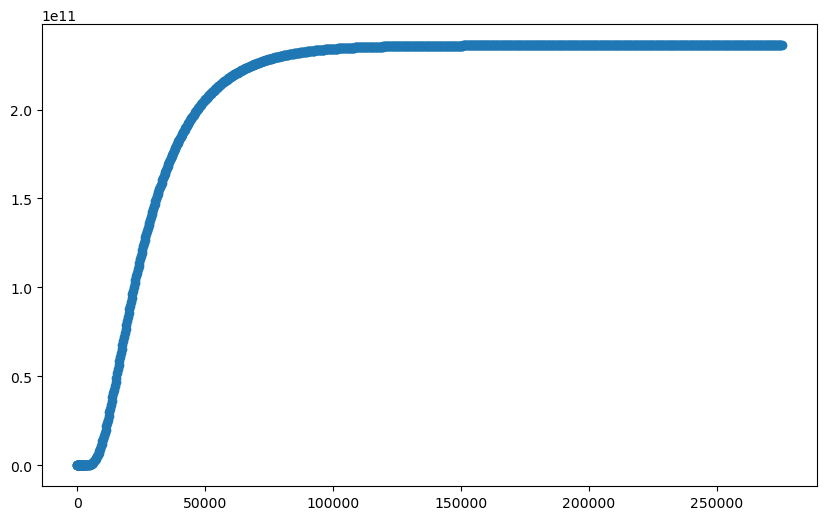

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

times = np.asarray(times)
flux  = np.asarray(permeation_flux.data)

# milestones from temp_schedule
milestones_arr = np.asarray(milestones)

# ---------------------------------------
# Split into segments (runs and bakes) with temperature info
# ---------------------------------------
segments = []  # each item: (segment_type, temperature, times, flux)

t_prev = 0.0

for k, (m, temp, phase) in enumerate(temp_schedule):
    mask = (times > t_prev) & (times <= m)
    seg_times = times[mask]
    seg_flux  = flux[mask]
    
    segments.append((phase, temp, seg_times, seg_flux))
    t_prev = m

# ---------------------------------------
# Extract only the runs
# ---------------------------------------
run_segments = [(temp, t, f) for (typ, temp, t, f) in segments if typ == "run"]

# Group runs by temperature step
temp_groups = {}
run_counter = 0

for temp_idx, temp in enumerate(temperatures):
    temp_key = f"{temp}K_step{temp_idx+1}"
    temp_groups[temp_key] = []
    
    for _ in range(runs_per_temp):
        if run_counter < len(run_segments):
            temp_groups[temp_key].append(run_segments[run_counter])
            run_counter += 1

# ---------------------------------------
# Plot each temperature group separately
# ---------------------------------------
for temp_key, runs in temp_groups.items():
    if len(runs) == 0:
        continue
        
    plt.figure(figsize=(10, 6))
    
    for i, (temp, t_seg, f_seg) in enumerate(runs, start=1):
        # Shift ALL runs to start at zero
        t_plot = t_seg - t_seg[0]
        
        plt.plot(t_plot, np.abs(f_seg), "o-", label=f"run {i}")
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Downstream flux (H/m²/s)")
    plt.title(f"Permeation runs at {temp_key}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print(f"\nTotal runs plotted: {run_counter}")
print(f"Temperature groups: {list(temp_groups.keys())}")


600K_step1:
  Max flux (run 1): 8.058e+07
  Threshold (5.0%): 4.029e+06


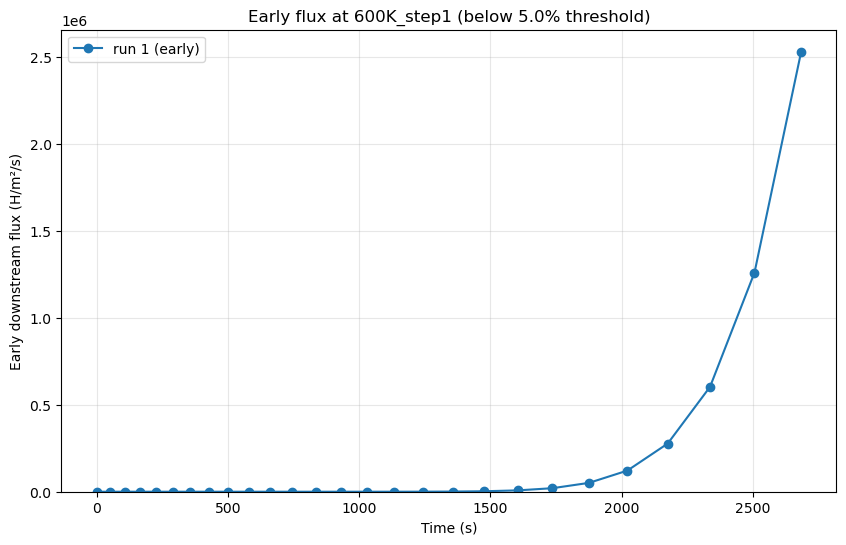


550K_step2:
  Max flux (run 1): 8.240e+10
  Threshold (5.0%): 4.120e+09


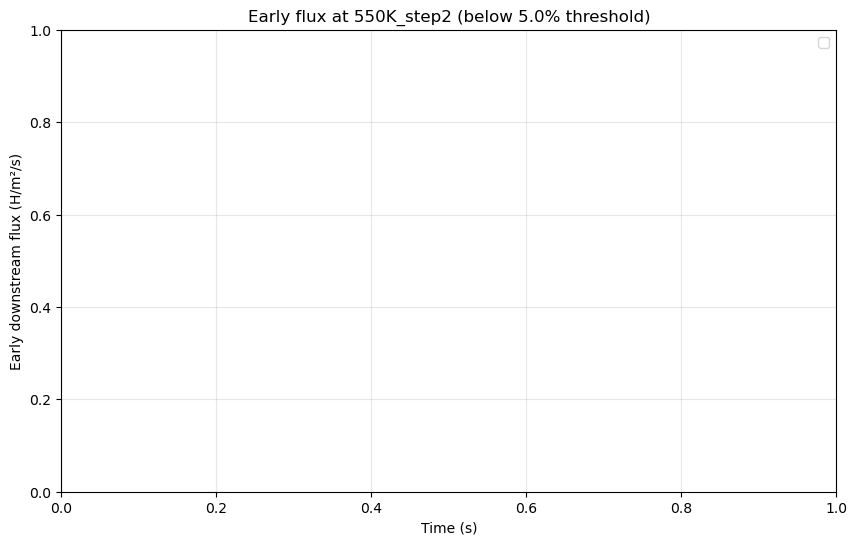


500K_step3:
  Max flux (run 1): 1.052e+11
  Threshold (5.0%): 5.260e+09


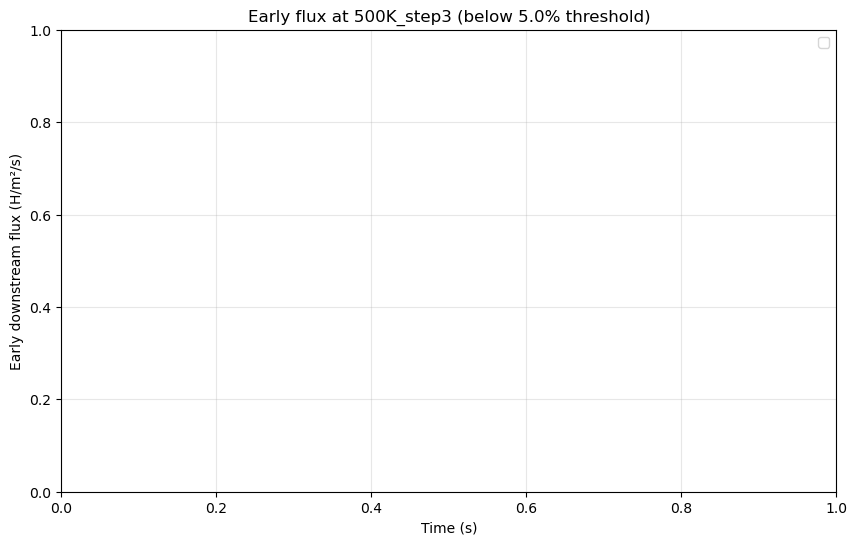


550K_step4:
  Max flux (run 1): 1.081e+11
  Threshold (5.0%): 5.407e+09


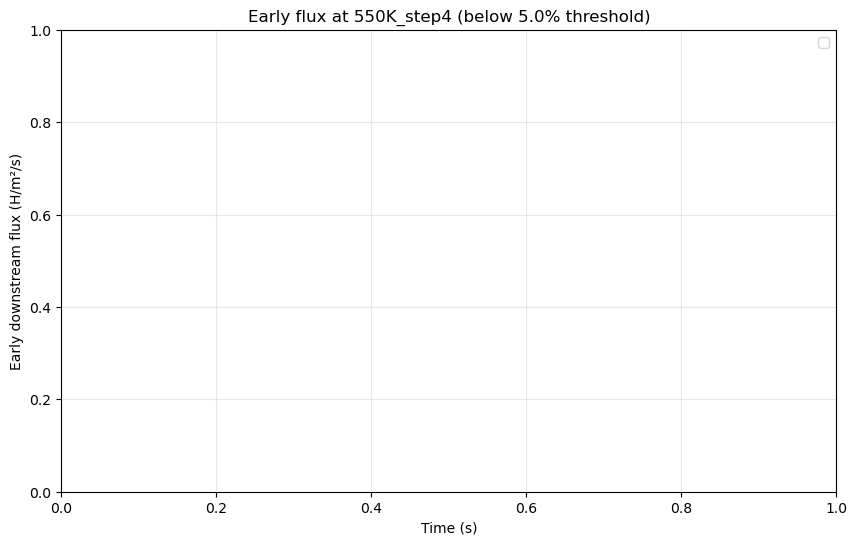


600K_step5:
  Max flux (run 1): 1.086e+11
  Threshold (5.0%): 5.430e+09


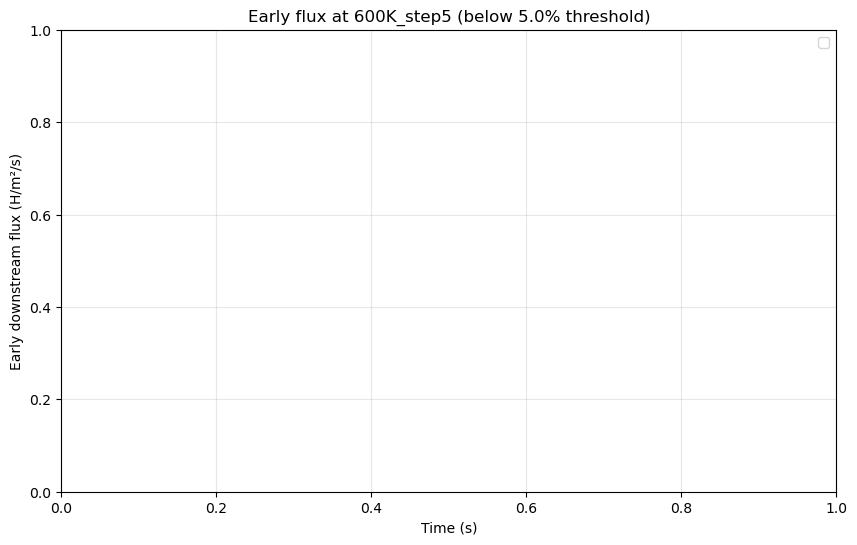

In [ ]:
pct = 0.05  # e.g., 5% of the maximum flux from first run of each temp group

# ---------------------------------------
# Analyze early flux for each temperature group
# ---------------------------------------
temp_early_data = {}  # store early flux data for comparison

for temp_key, runs in temp_groups.items():
    if len(runs) == 0:
        continue
    
    # Get max flux from first run of this temperature group
    first_run_temp, first_run_times, first_run_flux = runs[0]
    max_flux_first = np.max(np.abs(first_run_flux))
    threshold = pct * max_flux_first
    
    print(f"\n{temp_key}:")
    print(f"  Max flux (run 1): {max_flux_first:.3e}")
    print(f"  Threshold ({pct*100:.1f}%): {threshold:.3e}")
    
    # Extract early flux for each run in this group
    early_runs = []
    
    for i, (temp, t_seg, f_seg) in enumerate(runs, start=1):
        f_abs = np.abs(f_seg)
        mask = f_abs <= threshold
        
        t_early = t_seg[mask]
        f_early = f_abs[mask]
        
        early_runs.append((t_early, f_early))
    
    # Store for comparison plot
    temp_early_data[temp_key] = {
        'temperature': first_run_temp,
        'early_runs': early_runs,
        'threshold': threshold
    }
    
    # Plot early portions for this temperature group
    plt.figure(figsize=(10, 6))
    
    for i, (t_early, f_early) in enumerate(early_runs, start=1):
        if len(t_early) == 0:
            continue
        
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        
        plt.plot(t_plot, f_early, "-o", label=f"run {i} (early)")
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early downstream flux (H/m²/s)")
    plt.title(f"Early flux at {temp_key} (below {pct*100}% threshold)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

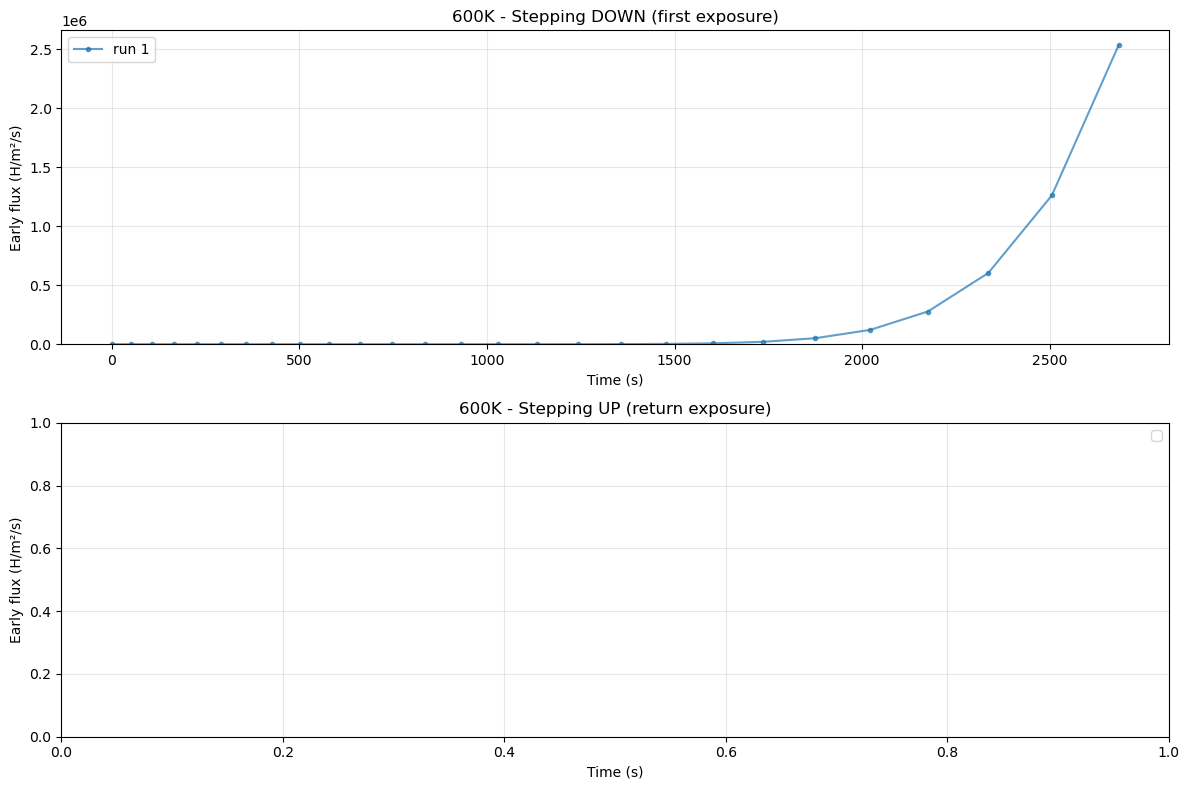


Comparison for 600K:


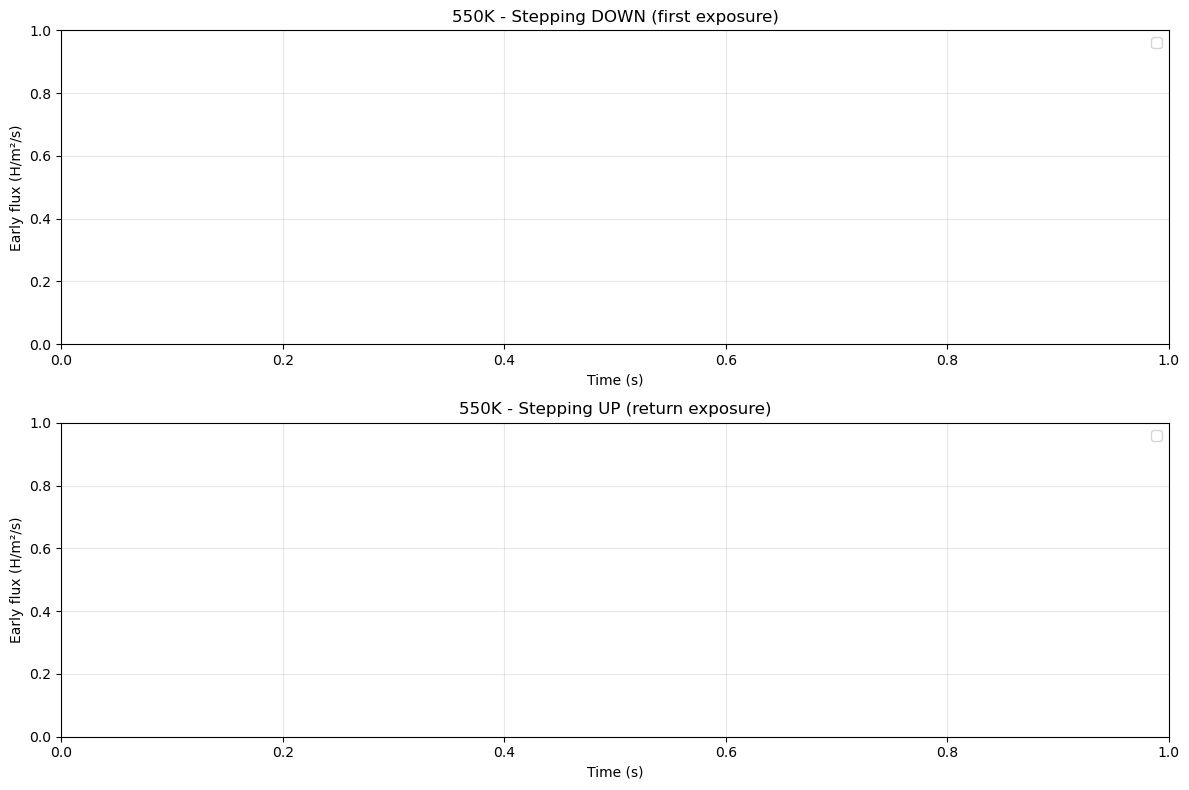


Comparison for 550K:


In [ ]:
# ---------------------------------------
# Comparison: Temperature stepping down vs stepping up
# ---------------------------------------
# Compare the 5% early flux behavior between:
# - 600K_step1 (initial, stepping down)
# - 600K_step5 (final, after stepping up)
# And similarly for 550K

# Identify matching temperature steps
comparison_pairs = [
    ('600K_step1', '600K_step5', '600K'),  # stepping down vs stepping up
    ('550K_step2', '550K_step4', '550K'),  # stepping down vs stepping up
]

for down_key, up_key, temp_label in comparison_pairs:
    if down_key not in temp_early_data or up_key not in temp_early_data:
        print(f"Missing data for comparison: {down_key} or {up_key}")
        continue
    
    down_data = temp_early_data[down_key]
    up_data = temp_early_data[up_key]
    
    plt.figure(figsize=(12, 8))
    
    # Plot stepping down (first occurrence of this temperature)
    plt.subplot(2, 1, 1)
    for i, (t_early, f_early) in enumerate(down_data['early_runs'], start=1):
        if len(t_early) == 0:
            continue
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        plt.plot(t_plot, f_early, label=f"run {i}", marker='o', markersize=3, alpha=0.7)
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early flux (H/m²/s)")
    plt.title(f"{temp_label} - Stepping DOWN (first exposure)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot stepping up (return to this temperature)
    plt.subplot(2, 1, 2)
    for i, (t_early, f_early) in enumerate(up_data['early_runs'], start=1):
        if len(t_early) == 0:
            continue
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        plt.plot(t_plot, f_early, label=f"run {i}", marker='s', markersize=3, alpha=0.7)
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early flux (H/m²/s)")
    plt.title(f"{temp_label} - Stepping UP (return exposure)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison metrics
    print(f"\n{'='*60}")
    print(f"Comparison for {temp_label}:")
    print(f"{'='*60}")
    
    # Compare first runs
    if len(down_data['early_runs'][0][0]) > 0 and len(up_data['early_runs'][0][0]) > 0:
        down_t1, down_f1 = down_data['early_runs'][0]
        up_t1, up_f1 = up_data['early_runs'][0]
        
        down_duration = down_t1[-1] - down_t1[0] if len(down_t1) > 1 else 0
        up_duration = up_t1[-1] - up_t1[0] if len(up_t1) > 1 else 0
        
        print(f"  Stepping DOWN - Run 1 early phase duration: {down_duration:.2e} s")
        print(f"  Stepping UP   - Run 1 early phase duration: {up_duration:.2e} s")
        
        if down_duration > 0:
            change_pct = ((up_duration - down_duration) / down_duration) * 100
            print(f"  Change: {change_pct:+.1f}%")
            
            if up_duration > down_duration:
                print(f"  → Early phase is LONGER when stepping up (more trapped H)")
            elif up_duration < down_duration:
                print(f"  → Early phase is SHORTER when stepping up (less trapped H)")
            else:
                print(f"  → Early phase duration is similar")